In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df=pd.read_csv("data/transfers_test.csv")

In [3]:
df.shape

(100000, 12)

In [4]:
# 데이터 확인
df.head()

,type,txhash,timestamp,amount,denom,dpDenom,fromAddress,toAddress,fromChain,fromChainId,toChain,toChainId
0,Send,413D0BB67CBC4A66B2C32ECDD1C5974BCB6BBF012D6C7F...,1667135085000,7.21600,uatom,ATOM,cosmos1gwyv83zcnckdhuz3n78rvyzj59u8x6l8dk9cfy,cosmos1v0zv6s67mt7hqv6ky7au3pkqw3xcpp78pnp4uj,cosmos,cosmoshub-4,cosmos,cosmoshub-4
1,Send,931A14D99B42D18EA2BD5C61105489880BF1F7939A758B...,1667135085000,6.55626,uatom,ATOM,cosmos153lf4zntqt33a4v0sm5cytrxyqn78q7kz8j8x5,cosmos1q8mwcpw4x0kpskajuglgkhevpunujy3c2ekyh6,cosmos,cosmoshub-4,cosmos,cosmoshub-4
2,Send,ADA7DE328D1C68DA26F9721FCB407A41059C79F0C83C06...,1667135085000,3.00000,uatom,ATOM,cosmos1k77ggtxdd7fnahadu9nycpjmlnt87aq4cttcgx,cosmos1psr5x3kgra5fvm4gc4l6ufykn0nl3esdjeex8n,cosmos,cosmoshub-4,cosmos,cosmoshub-4
3,Send,08C37BBC858078112C461D81842F0B64C765E0FEC03946...,1667135086000,649.80000,uscrt,SCRT,secret1an5pyzzpu5ez7ep9m43yzmalymwls39qtk8rjd,secret1y9chu4ee326g9ay02nyv2sh7hhquz9sx52k785,secret,secret-4,secret,secret-4
4,Send,C8310F1D40F50A019BD76F5862E7B8D9B36DF4E33F3672...,1667135086000,500.00000,inj,INJ,inj17lw6c2xxflhljt3sty3sch9kpvfhcz98apdj8d,inj1u2rajhqtptzvu23leheta9yg99k3hazf4waf43,injective,injective-1,injective,injective-1


In [5]:
# IBCReceive 제거
df = df[df['type'] != 'IBCReceive']

In [6]:
df['is_external'] = df['fromChain'] != df['toChain']

In [7]:
# 보낸 사람 기준
from_df = df[['fromAddress', 'amount', 'is_external']].copy()
from_df.columns = ['address', 'amount', 'is_external']
from_df['direction'] = 'from'

# 받은 사람 기준
to_df = df[['toAddress', 'amount', 'is_external']].copy()
to_df.columns = ['address', 'amount', 'is_external']
to_df['direction'] = 'to'

# 합치기
node_df = pd.concat([from_df, to_df])


In [8]:
# 전체 거래 횟수 및 거래량
total_stats = node_df.groupby('address').agg(
    total_tx_count = ('amount', 'count'),
    total_tx_amount = ('amount', 'sum')
)

# 외부 체인 거래만 필터링
external_df = node_df[node_df['is_external']]

external_stats = external_df.groupby('address').agg(
    external_tx_count = ('amount', 'count'),
    external_tx_amount = ('amount', 'sum')
)

# 병합
node_stats = total_stats.join(external_stats, how='left').fillna(0)

# 0~100 정규화
for col in node_stats.columns:
    max_val = node_stats[col].max()
    if max_val > 0:
        node_stats[col + '_scaled'] = (node_stats[col] / max_val * 100).round(2)


In [9]:
node_df.groupby('address').agg(
    total_tx_count = ('amount', 'count'),
    total_tx_amount = ('amount', 'sum')
).reset_index().sort_values(by='total_tx_count', ascending=False).head(10)


,address,total_tx_count,total_tx_amount
22093,fetch1a4t2hja6yu4khksmhl2ld96gjwkysnvavclgyt,4643,34782.540517
21234,fetch14qvv6p4whrpp0409dxggn22s2z3cftp7042530,2606,633.793404
23198,fetch1jf5q7gzyj78n3wgtsjh0cmuna3zvj43knqu9vv,2574,647.994298
24022,fetch1pqffxze6x8nnjgt2k63g0z97aswhjuspwa2zac,2526,604.401817
23947,fetch1p5pzh0luer9vd69dqzpgzkra3n9hw8mnmvwgn9,2525,598.045948
24534,fetch1t3qet68dr0qkmrjtq89lrx837qa2t05265qy6s,2516,603.695088
23515,fetch1lezqmc0gq3vrz3rurprqu2lz0fh0udt8u4c0ng,2509,601.966415
24513,fetch1sxzs93a2le7fs3ktlqs0wjsjcpddr2nhuwg4sm,2504,592.221772
23066,fetch1hhtp9wdyy7p56y3l0hmcukssqeku92agwyts2a,2501,571.431562
20891,fetch12hevarwwwhm9rszfqpzl2lxhs9kgpdwrdxkhjg,2499,564.874037


<Figure size 1500x1000 with 0 Axes>

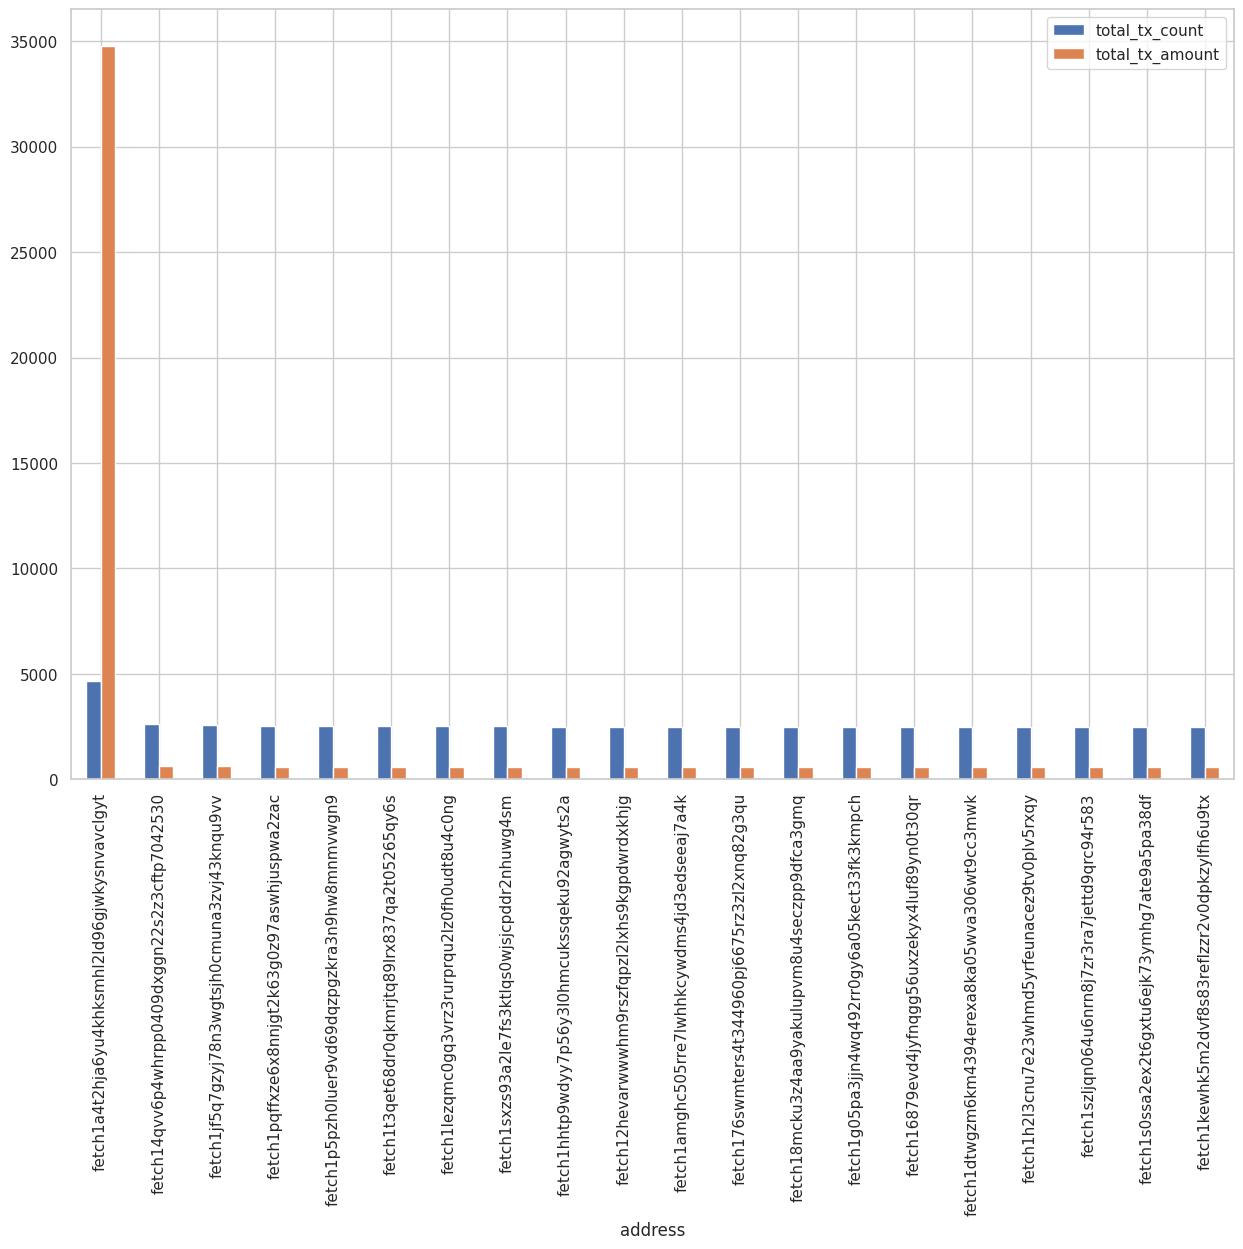

In [10]:
#파생변수들 그래프그리기
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
node_stats = node_stats.reset_index()
node_stats = node_stats.sort_values(by='total_tx_count', ascending=False).head(20)
node_stats = node_stats.set_index('address')
node_stats[['total_tx_count', 'total_tx_amount']].plot(kind='bar', figsize=(15, 10))
plt.show()

In [11]:
#파생변수들 그래프그리기
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
node_stats = node_stats.reset_index()
node_stats = node_stats.sort_values(by='external_tx_count', ascending=False).head(20)
node_stats = node_stats.set_index('address')
node_stats[['externam_tx_count', 'external_tx_amount']].plot(kind='bar', figsize=(15, 10))
plt.show()

KeyError: "['externam_tx_count'] not in index"

<Figure size 1500x1000 with 0 Axes>

In [ ]:
node_stats

,total_tx_count,total_tx_amount,external_tx_count,external_tx_amount,total_tx_count_scaled,total_tx_amount_scaled,external_tx_count_scaled,external_tx_amount_scaled
address,,,,,,,,
fetch1a4t2hja6yu4khksmhl2ld96gjwkysnvavclgyt,4643,34782.540517,0.0,0.0,100.00,0.0,0.0,0.0
fetch14qvv6p4whrpp0409dxggn22s2z3cftp7042530,2606,633.793404,0.0,0.0,56.13,0.0,0.0,0.0
fetch1jf5q7gzyj78n3wgtsjh0cmuna3zvj43knqu9vv,2574,647.994298,0.0,0.0,55.44,0.0,0.0,0.0
fetch1pqffxze6x8nnjgt2k63g0z97aswhjuspwa2zac,2526,604.401817,0.0,0.0,54.40,0.0,0.0,0.0
fetch1p5pzh0luer9vd69dqzpgzkra3n9hw8mnmvwgn9,2525,598.045948,0.0,0.0,54.38,0.0,0.0,0.0
fetch1t3qet68dr0qkmrjtq89lrx837qa2t05265qy6s,2516,603.695088,0.0,0.0,54.19,0.0,0.0,0.0
fetch1lezqmc0gq3vrz3rurprqu2lz0fh0udt8u4c0ng,2509,601.966415,0.0,0.0,54.04,0.0,0.0,0.0
fetch1sxzs93a2le7fs3ktlqs0wjsjcpddr2nhuwg4sm,2504,592.221772,0.0,0.0,53.93,0.0,0.0,0.0
fetch1hhtp9wdyy7p56y3l0hmcukssqeku92agwyts2a,2501,571.431562,0.0,0.0,53.87,0.0,0.0,0.0
